# Q1. Play with the hyper-parameters such as learning rate, batch size, optimizer, and layers to generate good quality images.

In [1]:
#https://www.datacamp.com/community/tutorials/generative-adversarial-networks
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imquality.brisque as brisque

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [184]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [185]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [186]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [187]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [188]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [189]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

## Normal Run: Epoch: 2, Learning Rate: 0.0002, Batch Size: 128

--------------- Epoch 0 ---------------


100%|██████████| 468/468 [02:15<00:00,  3.45it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [02:40<00:00,  2.92it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [02:19<00:00,  3.36it/s]


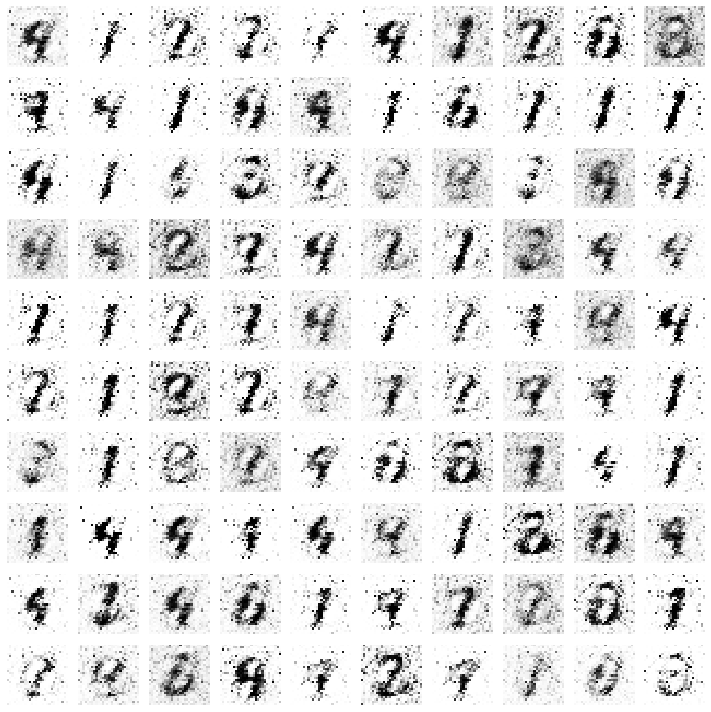

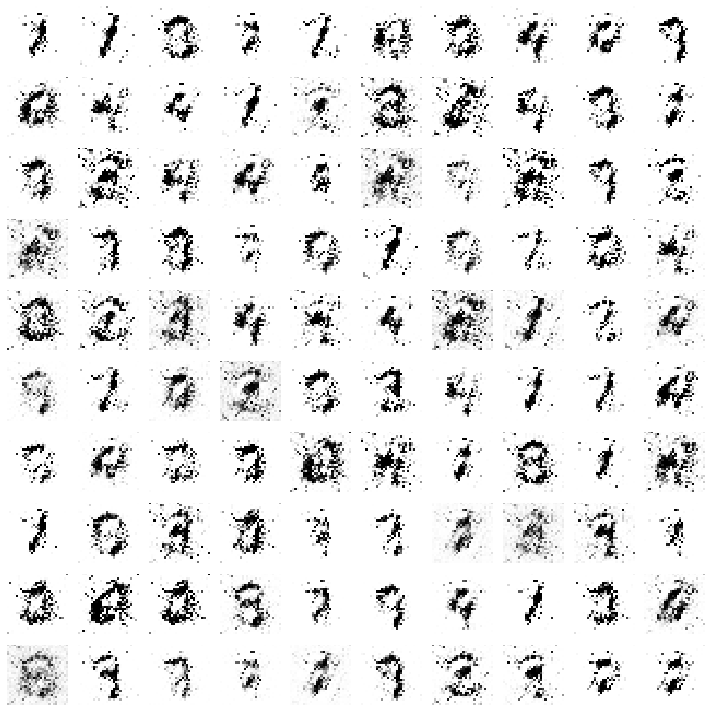

In [221]:
if __name__ == '__main__':
    train(2, 128)

## Doubling Batch Size: Epoch: 2, Learning Rate: 0.0002, Batch Size: 256

--------------- Epoch 0 ---------------


100%|██████████| 234/234 [01:23<00:00,  2.81it/s]


--------------- Epoch 1 ---------------


100%|██████████| 234/234 [01:24<00:00,  2.78it/s]


--------------- Epoch 2 ---------------


100%|██████████| 234/234 [01:27<00:00,  2.66it/s]


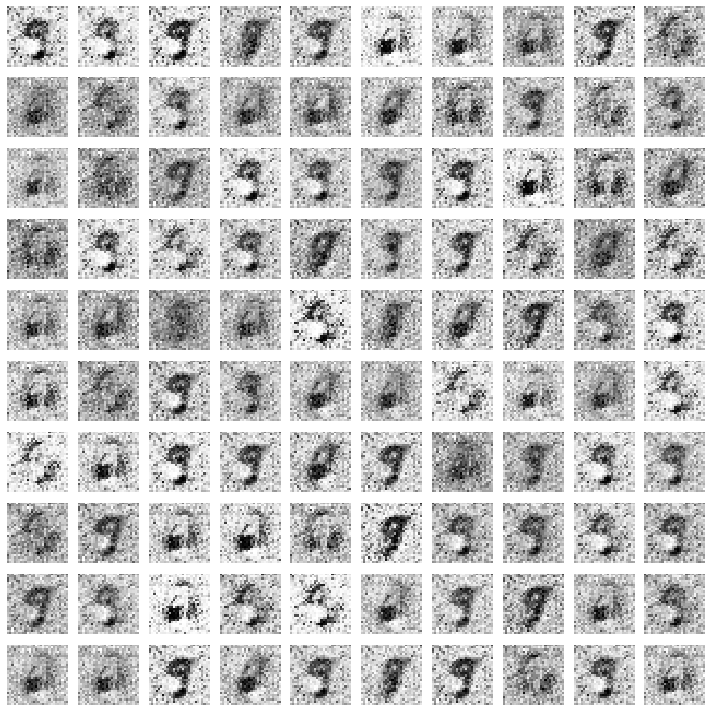

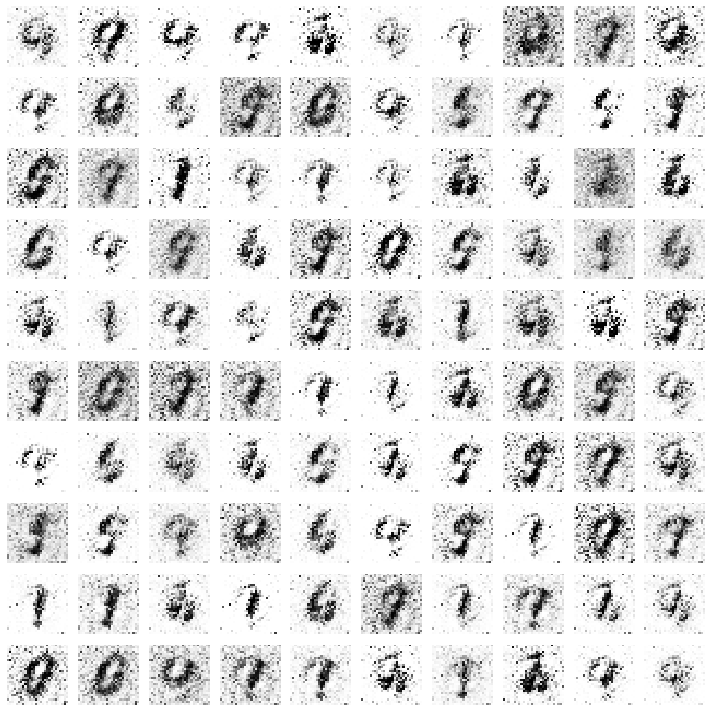

In [50]:
if __name__ == '__main__':
    train(2, 256)

## Increasing Learning Rate: Epoch: 2, Learning Rate: 0.01, Batch Size: 128

In [37]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.01, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [38]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [39]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [40]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

--------------- Epoch 0 ---------------


100%|██████████| 468/468 [02:14<00:00,  3.48it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [02:27<00:00,  3.18it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [02:16<00:00,  3.43it/s]


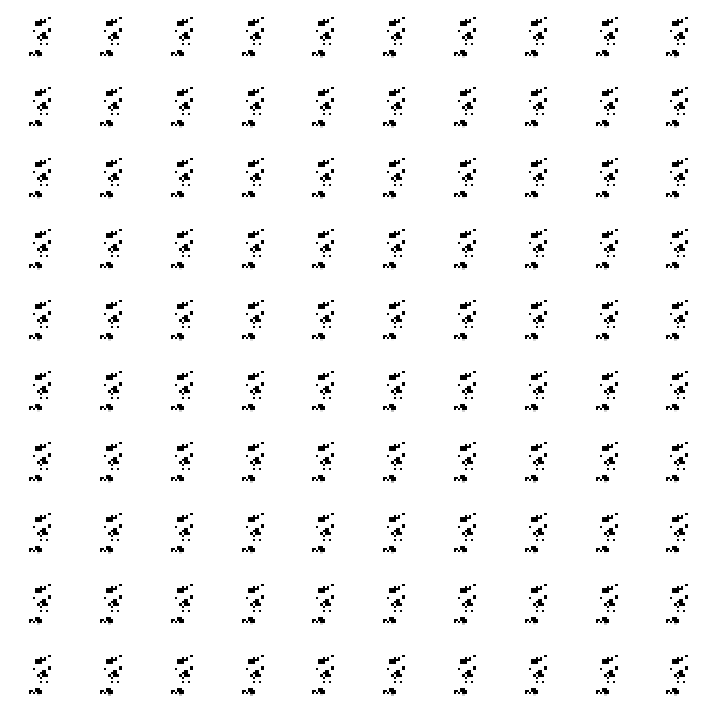

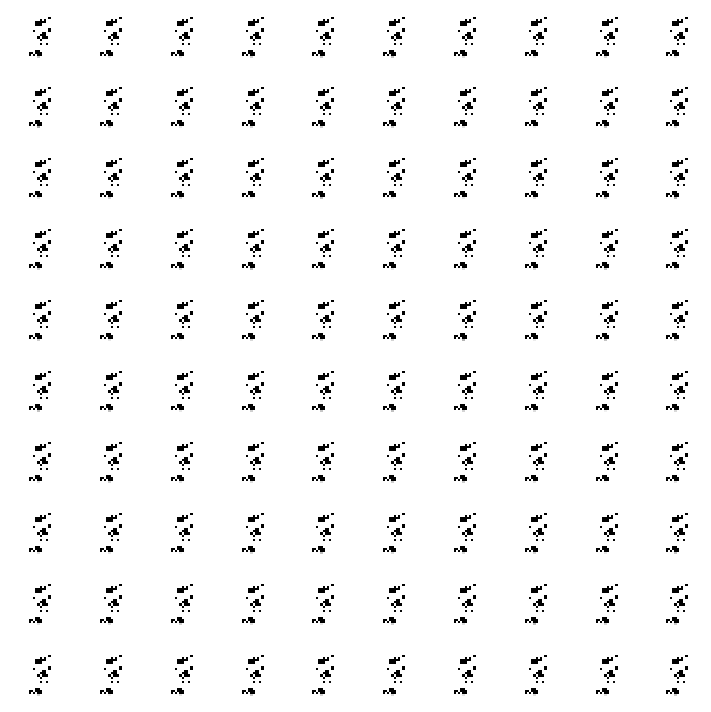

In [41]:
if __name__ == '__main__':
    train(2, 128)

## Increasing Epoch by 5 times: Epoch: 10, Learning Rate: 0.0002, Batch Size: 128

In [24]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [25]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [26]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [27]:
import math
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(math.floor(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

--------------- Epoch 0 ---------------


100%|██████████| 468/468 [02:17<00:00,  3.41it/s]


--------------- Epoch 1 ---------------


100%|██████████| 468/468 [02:17<00:00,  3.41it/s]


--------------- Epoch 2 ---------------


100%|██████████| 468/468 [02:24<00:00,  3.24it/s]


--------------- Epoch 3 ---------------


100%|██████████| 468/468 [02:19<00:00,  3.36it/s]


--------------- Epoch 4 ---------------


100%|██████████| 468/468 [02:23<00:00,  3.27it/s]


--------------- Epoch 5 ---------------


100%|██████████| 468/468 [02:27<00:00,  3.18it/s]


--------------- Epoch 6 ---------------


100%|██████████| 468/468 [02:20<00:00,  3.32it/s]


--------------- Epoch 7 ---------------


100%|██████████| 468/468 [02:21<00:00,  3.31it/s]


--------------- Epoch 8 ---------------


100%|██████████| 468/468 [02:30<00:00,  3.11it/s]


--------------- Epoch 9 ---------------


100%|██████████| 468/468 [02:21<00:00,  3.31it/s]


--------------- Epoch 10 ---------------


100%|██████████| 468/468 [02:21<00:00,  3.30it/s]


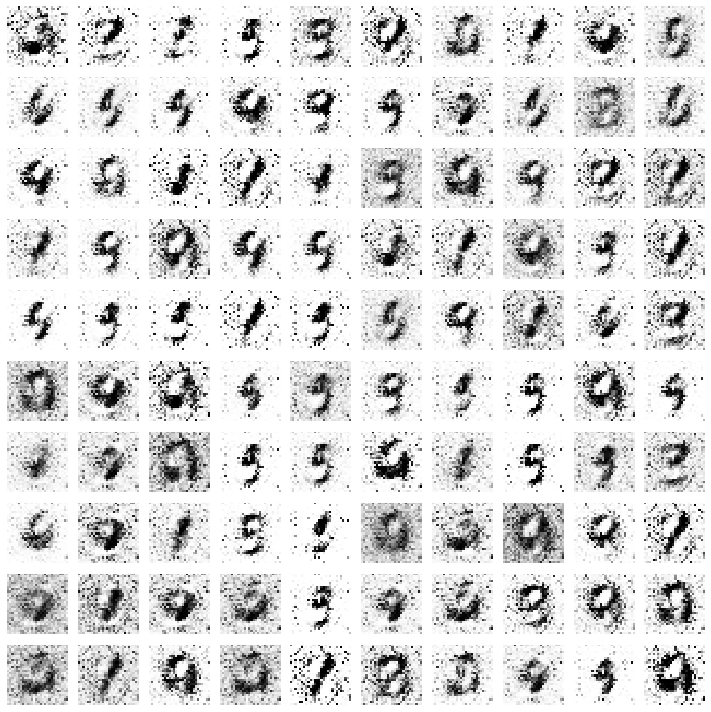

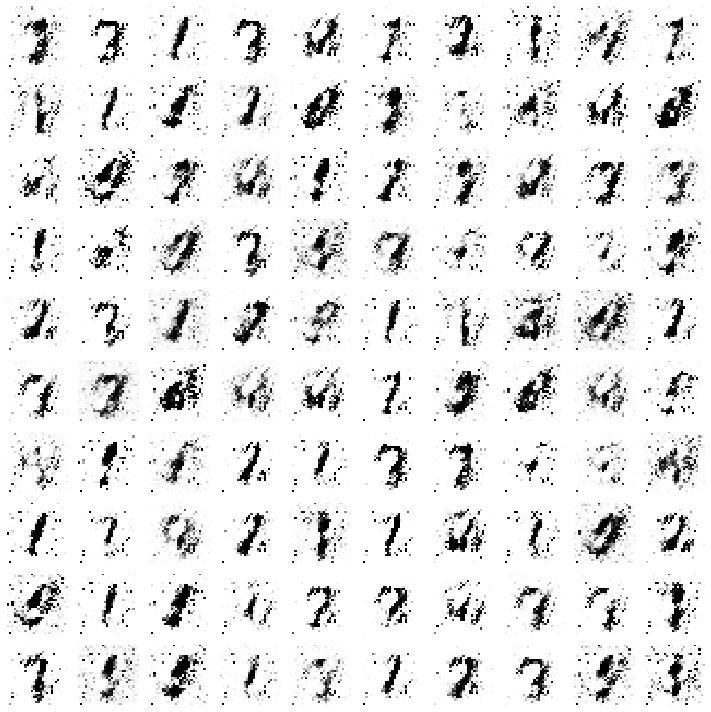

In [28]:
if __name__ == '__main__':
    train(10, 128)

# Q2. Calculate the image quality generated in each variation you have applied in your code and see what impact in terms of image quality you can observe.

In [22]:
import imquality.brisque as brisque
from PIL import Image
import glob
image_list = []

for filename in glob.glob('*.png'):
    img = Image.open(filename)
    image_list.append(np.array(img)[:,:,:3])

In [25]:
print("Normal Run: Epoch: 2, Learning Rate: 0.0002, Batch Size: 128") 
print("Score 1:", brisque.score(image_list[0]))
print("Score 2:", brisque.score(image_list[1]))
print("Doubling Batch Size: Epoch: 2, Learning Rate: 0.0002, Batch Size: 128") 
print("Score 1:", brisque.score(image_list[2]))
print("Score 2:", brisque.score(image_list[3]))
print("Increasing Learning Rate: Epoch: 2, Learning Rate: 0.01, Batch Size: 128") 
print("Score 1:", brisque.score(image_list[4]))
print("Score 2:", brisque.score(image_list[5]))
print("Increasing Epoch by 5 times: Epoch: 10, Learning Rate: 0.0002, Batch Size: 128") 
print("Score 1:", brisque.score(image_list[6]))
print("Score 2:", brisque.score(image_list[7]))

Normal Run: Epoch: 2, Learning Rate: 0.0002, Batch Size: 128
Score 1: 42.69625296148294
Score 2: 89.74249277373949
Doubling Batch Size: Epoch: 2, Learning Rate: 0.0002, Batch Size: 128
Score 1: 36.32040765069891
Score 2: 57.998883970302444
Increasing Learning Rate: Epoch: 2, Learning Rate: 0.01, Batch Size: 128
Score 1: 159.24949563546463
Score 2: 159.11778487433494
Increasing Epoch by 5 times: Epoch: 10, Learning Rate: 0.0002, Batch Size: 128
Score 1: 28.07438021282482
Score 2: 42.74635597455094


# Q3. Apply PCA on the CIFAR-10 dataset to reduce the dimensionality of the images and use the reduced dimension data for classification. For classification, you can use any classification architecture you have built so far for any assignment. However, make sure you can compare and contrast the performance of the same architecture when you use the classifier on original data vs. on reduced dimensional data. The comparisons can be done using metrics such as accuracy, errors, training-testing time, etc.

In [258]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D

In [259]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [260]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [261]:
classification_diff = [[],[]]

# Before Dimensionality Reduction

In [262]:
x_train_nn = x_train.reshape(50000, 3*32*32).astype('float32') / 255
x_test_nn = x_test.reshape(10000, 3*32*32).astype('float32') / 255
y_train_nn = y_train
y_test_nn = y_test

In [263]:
one_hot_encoder = OneHotEncoder(sparse = False)
one_hot_encoder.fit(y_train_nn)
y_train_nn = one_hot_encoder.transform(y_train_nn)
y_test_nn = one_hot_encoder.transform(y_test_nn)

In [264]:
model = Sequential()
x_shape = x_train_nn.shape[1:]

model.add(Dense(512, input_shape = x_shape))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [265]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [266]:
history2 = model.fit(x_train_nn, y_train_nn, epochs = 10 , batch_size = 128, validation_split = 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 11s 285us/sample - loss: 1.9690 - accuracy: 0.2849 - val_loss: 1.8239 - val_accuracy: 0.3438
Epoch 2/10
40000/40000 [==============================] - 10s 259us/sample - loss: 1.8196 - accuracy: 0.3377 - val_loss: 1.7444 - val_accuracy: 0.3818
Epoch 3/10
40000/40000 [==============================] - 10s 257us/sample - loss: 1.7670 - accuracy: 0.3577 - val_loss: 1.7010 - val_accuracy: 0.3932
Epoch 4/10
40000/40000 [==============================] - 10s 262us/sample - loss: 1.7254 - accuracy: 0.3765 - val_loss: 1.6819 - val_accuracy: 0.4086
Epoch 5/10
40000/40000 [==============================] - 11s 277us/sample - loss: 1.7070 - accuracy: 0.3842 - val_loss: 1.6418 - val_accuracy: 0.4132
Epoch 6/10
40000/40000 [==============================] - 11s 275us/sample - loss: 1.6698 - accuracy: 0.3960 - val_loss: 1.6305 - val_accuracy: 0.4180
Epoch 7/10
40000/40000 [====================

Text(0.5, 1.0, 'Accuracy Curves')

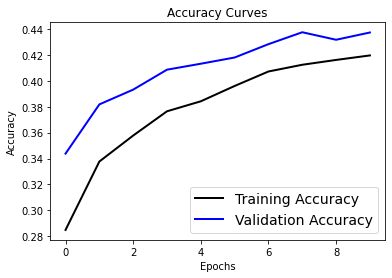

In [267]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history2.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history2.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [268]:
y_pred_nn = model.predict(x_test_nn)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
y_test_nn_classes = np.argmax(y_test_nn, axis=1)

In [269]:
nn_score = accuracy_score(y_test_nn_classes, y_pred_nn_classes)

In [270]:
cm4 = confusion_matrix(y_test_nn_classes, y_pred_nn_classes)

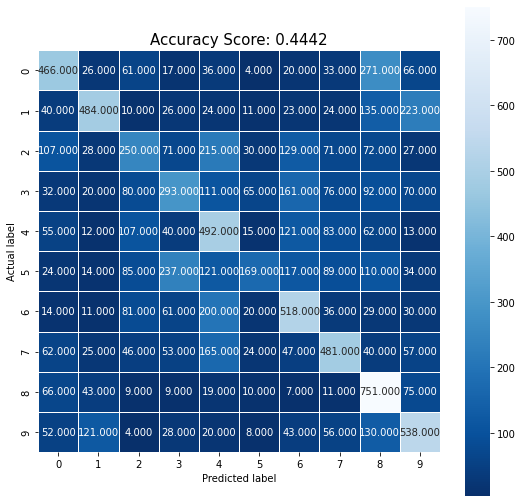

In [271]:
plt.figure(figsize = (9,9))
sns.heatmap(cm4, annot = True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(nn_score)
plt.title(all_sample_title, size = 15);

In [272]:
tp_and_fn = cm4.sum(1)
tp_and_fp = cm4.sum(0)
tp = cm4.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn

for i in range(10):
    print("Label: ",class_names[i],", Precision: ",precision[i],", Recall: ",recall[i])

Label:  airplane , Precision:  0.5076252723311547 , Recall:  0.466
Label:  automobile , Precision:  0.6173469387755102 , Recall:  0.484
Label:  bird , Precision:  0.34106412005457026 , Recall:  0.25
Label:  cat , Precision:  0.3508982035928144 , Recall:  0.293
Label:  deer , Precision:  0.35067712045616534 , Recall:  0.492
Label:  dog , Precision:  0.4747191011235955 , Recall:  0.169
Label:  frog , Precision:  0.43676222596964587 , Recall:  0.518
Label:  horse , Precision:  0.5010416666666667 , Recall:  0.481
Label:  ship , Precision:  0.4438534278959811 , Recall:  0.751
Label:  truck , Precision:  0.4748455428067079 , Recall:  0.538


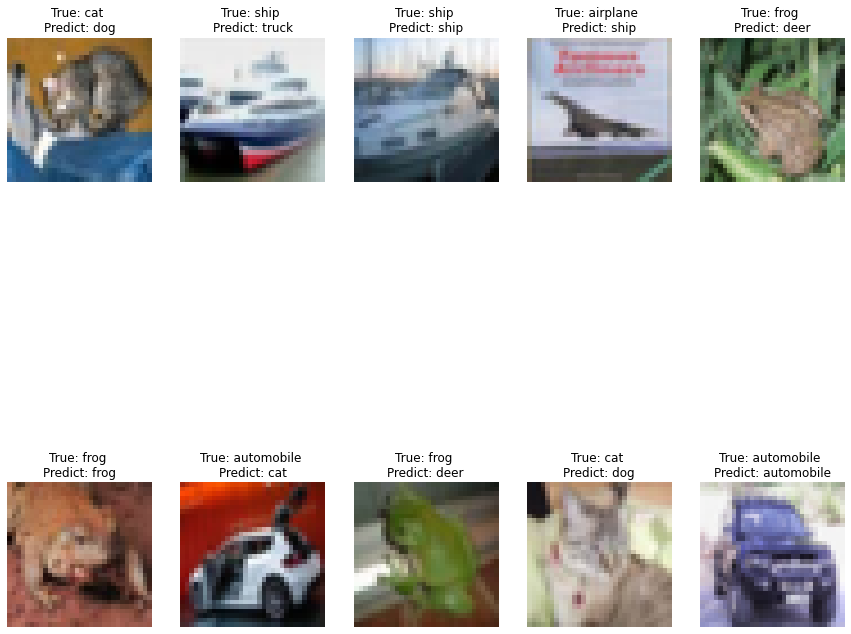

In [273]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(2, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 10):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[y_test_nn_classes[i]], class_names[y_pred_nn_classes[i]]))
    axes[i].axis('off')
    classification_diff[0].append([class_names[y_test_nn_classes[i]], class_names[y_pred_nn_classes[i]]])

## Apply PCA

In [274]:
from sklearn.decomposition import PCA

n_components = 150
pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(x_train_nn)
x_train_pca = pca.transform(x_train_nn)
x_test_pca = pca.transform(x_test_nn)

## After Dimensionality Reduction

In [275]:
model = Sequential()
x_shape = x_train_pca.shape[1:]

model.add(Dense(512, input_shape = x_shape))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [276]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [277]:
history2 = model.fit(x_train_pca, y_train_nn, epochs = 10 , batch_size = 128, validation_split = 0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 151us/sample - loss: 1.7890 - accuracy: 0.3606 - val_loss: 1.5644 - val_accuracy: 0.4466
Epoch 2/10
40000/40000 [==============================] - 5s 137us/sample - loss: 1.4511 - accuracy: 0.4873 - val_loss: 1.4250 - val_accuracy: 0.4983
Epoch 3/10
40000/40000 [==============================] - 6s 139us/sample - loss: 1.2816 - accuracy: 0.5458 - val_loss: 1.3352 - val_accuracy: 0.5324
Epoch 4/10
40000/40000 [==============================] - 6s 141us/sample - loss: 1.1558 - accuracy: 0.5926 - val_loss: 1.3165 - val_accuracy: 0.5438
Epoch 5/10
40000/40000 [==============================] - 6s 138us/sample - loss: 1.0668 - accuracy: 0.6191 - val_loss: 1.2994 - val_accuracy: 0.5470
Epoch 6/10
40000/40000 [==============================] - 5s 137us/sample - loss: 0.9846 - accuracy: 0.6539 - val_loss: 1.2804 - val_accuracy: 0.5516
Epoch 7/10
40000/40000 [==========================

Text(0.5, 1.0, 'Accuracy Curves')

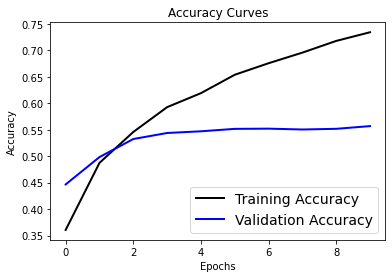

In [278]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history2.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history2.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [279]:
y_pred_nn = model.predict(x_test_pca)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
y_test_nn_classes = np.argmax(y_test_nn, axis=1)

In [280]:
nn_score = accuracy_score(y_test_nn_classes, y_pred_nn_classes)

In [281]:
cm4 = confusion_matrix(y_test_nn_classes, y_pred_nn_classes)

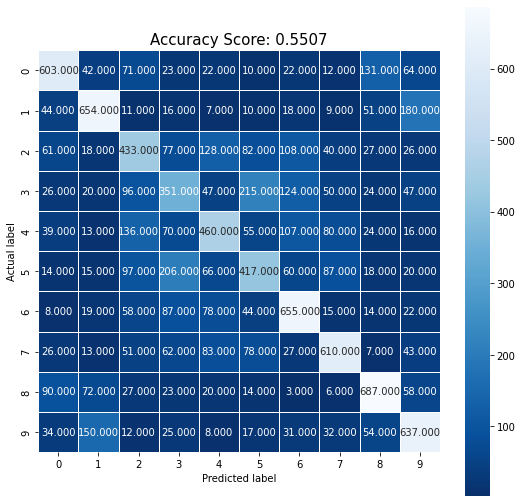

In [282]:
plt.figure(figsize = (9,9))
sns.heatmap(cm4, annot = True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(nn_score)
plt.title(all_sample_title, size = 15);

In [283]:
tp_and_fn = cm4.sum(1)
tp_and_fp = cm4.sum(0)
tp = cm4.diagonal()

precision = tp / tp_and_fp
recall = tp / tp_and_fn

for i in range(10):
    print("Label: ",class_names[i],", Precision: ",precision[i],", Recall: ",recall[i])

Label:  airplane , Precision:  0.638095238095238 , Recall:  0.603
Label:  automobile , Precision:  0.6437007874015748 , Recall:  0.654
Label:  bird , Precision:  0.43649193548387094 , Recall:  0.433
Label:  cat , Precision:  0.37340425531914895 , Recall:  0.351
Label:  deer , Precision:  0.500544069640914 , Recall:  0.46
Label:  dog , Precision:  0.4426751592356688 , Recall:  0.417
Label:  frog , Precision:  0.5670995670995671 , Recall:  0.655
Label:  horse , Precision:  0.6482465462274176 , Recall:  0.61
Label:  ship , Precision:  0.6624879459980714 , Recall:  0.687
Label:  truck , Precision:  0.5723270440251572 , Recall:  0.637


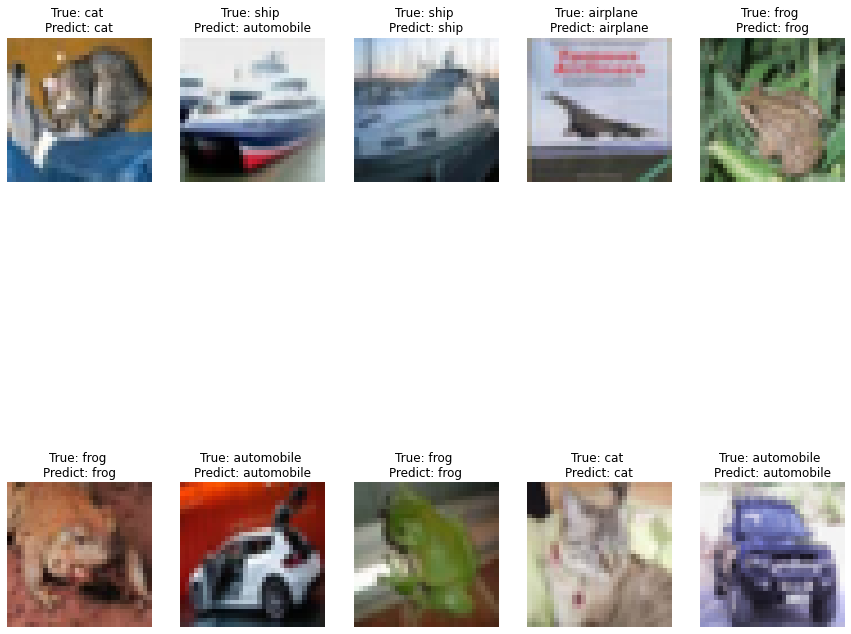

In [284]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(2, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 10):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[y_test_nn_classes[i]], class_names[y_pred_nn_classes[i]]))
    axes[i].axis('off')
    classification_diff[1].append([class_names[y_test_nn_classes[i]], class_names[y_pred_nn_classes[i]]])

## Classification Differences

In [285]:
classify = {
        'Before PCA':[],
        'After PCA':[]
}

In [286]:
for i in range(10):
    classify['Before PCA'].append(classification_diff[0][i][1]) 
    classify['After PCA'].append(classification_diff[1][i][1]) 

In [287]:
c = []
for i in range(10):
    c.append(classification_diff[0][i][0])

In [288]:
classify_pd = pd.DataFrame(classify, index = c)

### Here are the classification differences between different classifiers:

In [289]:
classify_pd

,Before PCA,After PCA
cat,dog,cat
ship,truck,automobile
ship,ship,ship
airplane,ship,airplane
frog,deer,frog
frog,frog,frog
automobile,cat,automobile
frog,deer,frog
cat,dog,cat
automobile,automobile,automobile


### Comments

#### -> Accuracy improved after applying PCA from 44% to 55%
#### -> Training time reduced to half
#### -> Classifications reduced from 7 misclassifications to just 1